In [14]:
#imported relevant and necessary libraries and data cleaning tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hypertools as hyp
from glob import glob as lsdir
import os
import re
import datetime as dt

from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

In [15]:
#code from Professor Manning to set up and read in the relevant UVLT data 
data_readers = {'xlsx': pd.read_excel, 'xls': pd.read_excel, 'dta': pd.read_stata}
get_extension = lambda x: x.split('.')[-1]


def read_data(datadir, readers):
    files = lsdir(os.path.join('..', datadir, '*'))
    readable_files = []
    data = []
    for f in files:
        ext = get_extension(f)
        if ext in readers.keys():
            readable_files.append(f)
            data.append(data_readers[ext](f))
    return readable_files, data


fnames, data = read_data('data', data_readers)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [16]:
#A summary of the data files that are now read into the notebook
fnames

['../data/UVLTdata_individual.dta',
 '../data/UVLTdata_final.dta',
 '../data/Direct Mailing Analysis.xlsx',
 '../data/UVLTDataAnalysis.xls',
 '../data/TownLevelData.xlsx',
 '../data/TownLevelData.dta',
 '../data/CensusInfoUpperValley2015JH.xlsx']

In [17]:
#this is the individual data
#Most of the initial cleaning that I have done has been on this data set, though it can be applied to others.
data[0].head()

,ContactID,State,TownID,Town,LandOwnerTownID,DeceasedDateYN,U_Tot_Amt,U_Tot_Cnt,U200001,U200102,...,E201112,E201213,E201314,E201415,E201516,E201617,E201718,E201819,DeceasedDate,ConservedOwner
0,1544.0,NC,60.0,All Other Towns,0.0,0.0,571.95,6.0,0.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
1,1545.0,NH,20.0,Lebanon,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2,1546.0,NH,61.0,All Other Towns NH,0.0,0.0,600.00,7.0,25.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
3,1547.0,VT,41.0,Weathersfield,41.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0
4,1548.0,VT,34.0,Springfield,0.0,1.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016.0,0.0


In [18]:
#Renaming relevant columns in UVLT individual data to be more easily readable
names={'DeceasedDateYN' : 'DeceasedYN',
       'U_Tot_Amt': 'Unrestricted_Tot_Amt',
      'U_Tot_Cnt': 'Unrestricted_Total_Count',
      'ConservedOwner' : 'Owns_Conserved_Land?',
      'RTotAmt' : 'Restricted_Tot_Amt',
       'RTotCnt': 'Restricted_Tot_Count',
      'VTotCnt' : 'Total_Volunteer_Occurances',
      'ETotCnt' : 'Total_Event_Attendances'}
data[0].rename(names, inplace=True, axis=1)

In [19]:
#Summary of the column values in data set 1
data[0].columns.values

array(['ContactID', 'State', 'TownID', 'Town', 'LandOwnerTownID',
       'DeceasedYN', 'Unrestricted_Tot_Amt', 'Unrestricted_Total_Count',
       'U200001', 'U200102', 'U200203', 'U200304', 'U200405', 'U200506',
       'U200607', 'U200708', 'U200809', 'U200910', 'U201011', 'U201112',
       'U201213', 'U201314', 'U201415', 'U201516', 'U201617', 'U201718',
       'U201819', 'Restricted_Tot_Amt', 'Restricted_Tot_Count', 'R200001',
       'R200102', 'R200203', 'R200304', 'R200405', 'R200506', 'R200607',
       'R200708', 'R200809', 'R200910', 'R201011', 'R201112', 'R201213',
       'R201314', 'R201415', 'R201516', 'R201617', 'R201718', 'R201819',
       'Total_Volunteer_Occurances', 'V200001', 'V200102', 'V200203',
       'V200304', 'V200405', 'V200506', 'V200607', 'V200708', 'V200809',
       'V200910', 'V201011', 'V201112', 'V201213', 'V201314', 'V201415',
       'V201516', 'V201617', 'V201718', 'V201819',
       'Total_Event_Attendances', 'E200001', 'E200102', 'E200203',
       'E20030

In [20]:
#copying each set of data into more memorably named versions
#I figured different analyses require different aspects of each dataframe, so starting here and using copies of the data for different analyses may be helpful for organization and fidelity
individual_data=data[0].copy()
final_data=data[1].copy()
mailing_data=data[2].copy()
town_data=data[5].copy()

#Similarly to the individual data, the final data could benefit from some cleaner column names
final_data.rename(names, inplace=True, axis=1)

In [30]:
to_drop={'U200001',
        'U200102',
        'U200203',
        'U200304',
        'U200405',
        'U200506',
        'U200607',
        'U200708',
        'U200809',
        'U200910',
        'U201011',
        'U201112',
        'U201213',
        'U201314',
        'U201415',
        'U201516',
        'U201617',
        'U201718',
        'U201819',
        'R200001', 
        'R200102',
        'R200203', 
        'R200304',
        'R200405', 
        'R200506', 
        'R200607', 
        'R200708', 
        'R200809', 
        'R200910',
        'R201011', 
        'R201112', 
        'R201213', 
        'R201314', 
        'R201415', 
        'R201516',
        'R201617', 
        'R201718', 
        'R201819',
        'V200001', 
        'V200102',
        'V200203', 
        'V200304', 
        'V200405', 
        'V200506', 
        'V200607', 
        'V200708',
        'V200809', 
        'V200910', 
        'V201011', 
        'V201112', 
        'V201213', 
        'V201314',
        'V201415', 
        'V201516', 
        'V201617', 
        'V201718', 
        'V201819',
        'E200001', 
        'E200102', 
        'E200203', 
        'E200304', 
        'E200405', 
        'E200506',
        'E200607', 
        'E200708', 
        'E200809',
        'E200910', 
        'E201011', 
        'E201112',
        'E201213',
        'E201314', 
        'E201415', 
        'E201516', 
        'E201617', 
        'E201718',
        'E201819',
        'ContactID'}

individual_data_summary=data[0].copy()

In [31]:
individual_data_summary.drop(to_drop, inplace=True, axis=1)

In [32]:
#The summary cleaning gets rid of the year-by-year data and leaves only the summary of the donations for analyses
individual_data_summary.head(15)

,State,TownID,Town,LandOwnerTownID,DeceasedYN,Unrestricted_Tot_Amt,Unrestricted_Total_Count,Restricted_Tot_Amt,Restricted_Tot_Count,Total_Volunteer_Occurances,Total_Event_Attendances,DeceasedDate,Owns_Conserved_Land?
0,NC,60.0,All Other Towns,0.0,0.0,571.95,6.0,0.0,0.0,0.0,0.0,NaN,0.0
1,NH,20.0,Lebanon,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2,NH,61.0,All Other Towns NH,0.0,0.0,600.00,7.0,0.0,0.0,0.0,0.0,NaN,0.0
3,VT,41.0,Weathersfield,41.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,1.0
4,VT,34.0,Springfield,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,2016.0,0.0
5,VT,13.0,Fairlee,13.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,1.0
6,NH,28.0,Plainfield,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
7,VT,36.0,Thetford,36.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,1.0
8,NH,20.0,Lebanon,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,2014.0,0.0
9,VT,40.0,Vershire,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,2014.0,0.0


In [33]:
individual_data_summary.sort_values('TownID')in

,State,TownID,Town,LandOwnerTownID,DeceasedYN,Unrestricted_Tot_Amt,Unrestricted_Total_Count,Restricted_Tot_Amt,Restricted_Tot_Count,Total_Volunteer_Occurances,Total_Event_Attendances,DeceasedDate,Owns_Conserved_Land?
11327,VT,2.0,Bradford,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
7905,VT,2.0,Bradford,2.0,0.0,0.0,0.0,45000.0,1.0,0.0,0.0,NaN,1.0
7895,VT,2.0,Bradford,0.0,0.0,25.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0
11318,VT,2.0,Bradford,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
3091,VT,2.0,Bradford,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
6416,VT,2.0,Bradford,0.0,0.0,350.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0
12927,VT,2.0,Bradford,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0
6399,VT,2.0,Bradford,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0
10975,VT,2.0,Bradford,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0
7916,VT,2.0,Bradford,0.0,0.0,75.0,2.0,0.0,0.0,0.0,0.0,NaN,0.0


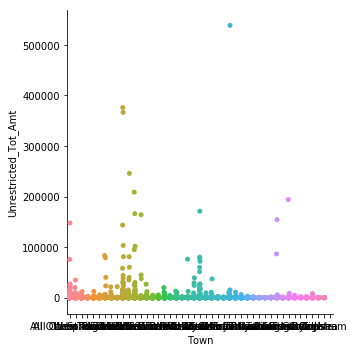

In [34]:
sns.catplot(x="Town", y="Unrestricted_Tot_Amt", data=individual_data_summary)